In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']


#BS_59
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
beh_directory = '..\\..\\Data\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

ModuleNotFoundError: No module named 'ruptures'

In [ ]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))
# animals = ['BS_51','BS_52','BS_56','BS_59','BS_61']

In [ ]:
print(animals)

In [ ]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

In [ ]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [ ]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    if sessionfile.meta.animal == 'BS_59':
        print('A')
    
    EnumSession.append(session)
    # for clust in sessionfile.clusters.good:
    #     EnumSession.append(session)
    #     EnumClust.append(clust)

In [ ]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

In [ ]:
def clean_up_lick_train(lick_train_ms,timeout_ms = 10):
    actual_licks = []
    last_lick = -np.Inf
    for lick in lick_train_ms:
        if (lick - last_lick) >= timeout_ms:
            actual_licks.append(lick)
        last_lick = lick
    return np.array(actual_licks)

In [ ]:
cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

animals_list = []
sessions_list = []
learning_phase_list = []
avg_lick_rate_list = []
avg_go_lick_rate_list = []
post_stim_limit = []

post_stim = 0.25 #seconds
for idx,session in tqdm(enumerate(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    licks = sessionfile.behavior.lick_times
   
    allconds = ilep.getAllConditions(sessionfile,clust=None)
    
    number_of_licks = []
    trials = allconds['all_trials'].trials
    for trial in trials:
        trialstart = sessionfile.trials.starts[trial] - 0.05 * sessionfile.meta.fs
        trialend = trialstart + post_stim * sessionfile.meta.fs
        in_trial_licks = np.logical_and(np.greater(licks,trialstart),np.less(licks,trialend))
        in_trial_licks = licks[in_trial_licks]
        in_trial_licks = clean_up_lick_train(in_trial_licks/30, timeout_ms = 1)
        number_of_licks.append(len(in_trial_licks))
        
    number_of_licks_go_only = []
    trials = allconds['go'].trials
    for trial in trials:
        trialstart = sessionfile.trials.starts[trial] - 0.05 * sessionfile.meta.fs
        trialend = trialstart + post_stim * sessionfile.meta.fs
        in_trial_licks = np.logical_and(np.greater(licks,trialstart),np.less(licks,trialend))
        in_trial_licks = licks[in_trial_licks]
        in_trial_licks = clean_up_lick_train(in_trial_licks/30, timeout_ms = 1)
        number_of_licks_go_only.append(len(in_trial_licks))

    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    learning_phase_list.append(EILphases[idx])

    avg_lick_rate_list.append(np.nanmean(number_of_licks))
    avg_go_lick_rate_list.append(np.nanmean(number_of_licks_go_only))
    post_stim_limit.append(post_stim)

In [ ]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['session'] = sessions_list
df_dict['learning phase'] = learning_phase_list

df_dict['average lick rate'] = avg_lick_rate_list
df_dict['average go lick rate'] = avg_go_lick_rate_list
df_dict['post-stimulus time limit'] = post_stim_limit

df = pd.DataFrame(df_dict)

In [ ]:
df

In [ ]:
prelate = df[df['learning phase'] == 'post late']

In [ ]:
len(prelate)

In [ ]:
np.max(df['average lick rate'])/0.2

In [12]:
lick_rate_preearly = []
lick_rate_prelate = []
lick_rate_preexpert = []
lick_rate_postearly = []
lick_rate_postlate = []
lick_rate_postexpert = []

post_stim = df['post-stimulus time limit'][0]

for row in df.iloc:
    if row['learning phase'] == 'pre early':
        lick_rate_preearly.append(row['average lick rate']/post_stim)
    if row['learning phase'] == 'pre late':
        lick_rate_prelate.append(row['average lick rate']/post_stim)
    if row['learning phase'] == 'pre expert':
        lick_rate_preexpert.append(row['average lick rate']/post_stim)
        
    if row['learning phase'] == 'post early':
        lick_rate_postearly.append(row['average lick rate']/post_stim)
    if row['learning phase'] == 'post late':
        lick_rate_postlate.append(row['average lick rate']/post_stim)
    if row['learning phase'] == 'post expert':
        lick_rate_postexpert.append(row['average lick rate']/post_stim)

lick_rate_preearly = np.array(lick_rate_preearly)
lick_rate_prelate = np.array(lick_rate_prelate)
lick_rate_preexpert = np.array(lick_rate_preexpert)
lick_rate_postearly = np.array(lick_rate_postearly)
lick_rate_postlate = np.array(lick_rate_postlate)
lick_rate_postexpert = np.array(lick_rate_postexpert)

1.163158407624725
2.6838694791003848
2.840975452883259
3.2961510291550917
3.590554849032686
2.773990245376897


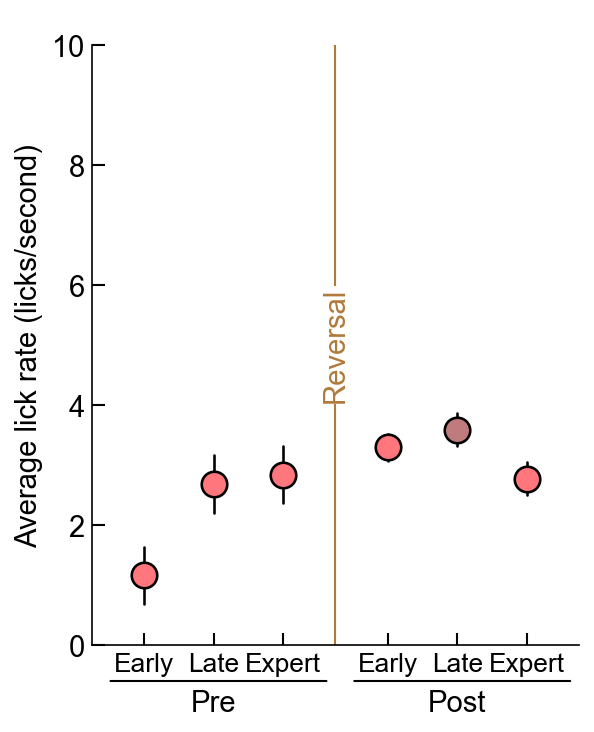

In [16]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 3.5
data = [lick_rate_preearly,lick_rate_prelate,lick_rate_preexpert,lick_rate_postearly,lick_rate_postlate,lick_rate_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

# ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
# ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    # Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)

    print(median)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,10])
# ax.set_yticks([0,2,4,6,8])
ylab = ax.set_ylabel('Average lick rate (licks/second)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = np.mean((ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-1],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+1],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Lick rate all trials V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [24]:
len(lick_rate_preearly)

6

In [22]:
# print(normaltest(lick_rate_preearly))
print(normaltest(lick_rate_prelate))
print(normaltest(lick_rate_preexpert))

print(normaltest(lick_rate_postearly))
print(normaltest(lick_rate_postlate))
print(normaltest(lick_rate_postexpert))

NormaltestResult(statistic=5.9899239324962705, pvalue=0.05003853020343615)
NormaltestResult(statistic=6.134308849235904, pvalue=0.046553437874286674)
NormaltestResult(statistic=2.414448649618468, pvalue=0.29902612799540845)
NormaltestResult(statistic=0.7329521178796852, pvalue=0.6931727315739682)
NormaltestResult(statistic=1.0169071064855935, pvalue=0.6014249316649758)


C:\Users\4thgr\anaconda3\envs\InsanallyLabEnv\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\4thgr\anaconda3\envs\InsanallyLabEnv\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [23]:
#Use this. Post is normal, Pre is not
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(lick_rate_preearly)
data_dec.prelate = np.abs(lick_rate_prelate)
data_dec.preexpert = np.abs(lick_rate_preexpert)
data_dec.postearly = np.abs(lick_rate_postearly)
data_dec.postlate = np.abs(lick_rate_postlate)
data_dec.postexpert = np.abs(lick_rate_postexpert)
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 6
pre-late    n = 17
pre-expert  n = 11
post-early  n = 33
post-late   n = 32
post-expert n = 29
pre-early  to pre-late   : 0.23426154318602832
pre-late   to pre-expert : 0.39714739546823563
pre-early  to pre-expert : 0.11070847178550221
post-early to post-late  : 0.39714739546823563
post-late  to post-expert: 0.11070847178550221
post-early to post-expert: 0.23745693182461164


In [19]:
p1 = ttest_ind(lick_rate_preearly,lick_rate_prelate).pvalue
p2 = ttest_ind(lick_rate_prelate,lick_rate_preexpert).pvalue
p3 = ttest_ind(lick_rate_preearly,lick_rate_preexpert).pvalue
p4 = ttest_ind(lick_rate_postearly,lick_rate_postlate).pvalue
p5 = ttest_ind(lick_rate_postlate,lick_rate_postexpert).pvalue
p6 = ttest_ind(lick_rate_postearly,lick_rate_postexpert).pvalue
ps = [p1,p2,p3,p4,p5,p6]
p_corrs = pg.multicomp(ps)
print(p_corrs)

(array([False, False, False, False, False, False]), array([0.37683912, 0.82793269, 0.23597586, 0.81978062, 0.23597586,
       0.43824766]))


In [19]:
lick_rate_preearly

array([2.11382114, 0.30588235, 0.1       , 0.13333333, 1.51162791,
       2.81428571])

In [20]:
lick_rate_prelate

array([2.725     , 2.33183857, 1.16071429, 0.92465753, 1.41      ,
       1.6765873 , 1.80300501, 2.65833333, 1.37931034, 2.43902439,
       0.57692308, 5.86538462, 3.87867647, 1.37184116, 6.67400881,
       6.95856874, 1.79190751])

In [21]:
ttest_ind(lick_rate_preearly,lick_rate_prelate)

TtestResult(statistic=-1.7528860346049433, pvalue=0.09420978072500452, df=21.0)

In [17]:
lick_rate_prelate

array([2.57963446, 7.15365239, 4.8       , 3.75853018, 2.57963446,
       4.8       ])

In [21]:
df[df['learning phase'] == 'pre late']['average go lick rate']/post_stim

5     3.523114
6     3.061224
16    1.927461
17    1.956522
18    2.087500
19    2.827068
20    2.579634
21    3.758530
22    1.821326
44    3.529412
54    4.800000
55    5.615385
56    6.074074
61    1.645933
62    7.153652
63    7.731020
78    1.902098
Name: average go lick rate, dtype: float64

In [22]:
df[df['learning phase'] == 'pre late']

,animal,session,learning phase,average lick rate,average go lick rate,post-stimulus time limit
5,BS_40,BS_40_10_AC.pickle,pre late,0.605000,0.880779,0.25
6,BS_40,BS_40_11_AC.pickle,pre late,0.504484,0.765306,0.25
16,BS_40,BS_40_2_AC.pickle,pre late,0.244898,0.481865,0.25
17,BS_40,BS_40_3_AC.pickle,pre late,0.207763,0.489130,0.25
18,BS_40,BS_40_4_AC.pickle,pre late,0.338000,0.521875,0.25
19,BS_40,BS_40_5_AC.pickle,pre late,0.373016,0.706767,0.25
20,BS_40,BS_40_6_AC.pickle,pre late,0.414023,0.644909,0.25
21,BS_40,BS_40_7_AC.pickle,pre late,0.598333,0.939633,0.25
22,BS_40,BS_40_8_AC.pickle,pre late,0.324544,0.455331,0.25
44,BS_49,BS_49_10_AC.pickle,pre late,0.548780,0.882353,0.25


In [ ]:
#Outlier = BS_50 	BS_50_6_AC.pickle 	pre late 	1.563877 	1.788413 	0.25

In [24]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_50_6_AC.pickle')

In [27]:
sessionfile.behavior

namespace(lick_times=array([1.0000000e+00, 4.6800000e+03, 4.6840000e+03, ..., 6.7322956e+07,
                            6.7322958e+07, 6.7322961e+07]),
          reward_times=array([   69506.,   171261.,   272689.,   373649.,   474789.,   575939.,
                                897932.,  1222875.,  1771327.,  2535779.,  2639670.,  2740856.,
                               2846982.,  3390163.,  3711974.,  3813126.,  4135687.,  4236139.,
                               4779910.,  5322628.,  5644695.,  5967796.,  6100988.,  6202398.,
                               6745338.,  7067585.,  7394397.,  7495656.,  8038345.,  8139041.,
                               8903516.,  9004393.,  9327420.,  9428689.,  9529729.,  9851207.,
                               9952482., 10947755., 11271433., 11373016., 11696698., 11797596.,
                              12121342., 12666825., 12768126., 13314745., 13637186., 13962645.,
                              14507101., 14608161., 15152042., 15476983., 15801

In [30]:
dir = os.path.join('S:\\Sorts\\DualRecording',sessionfile.meta.animal,'BS_50 8')
filename = os.path.join(dir,'licks.npy')
licktimes = np.load(filename)

In [39]:
sessionfile.meta

namespace(directory='D:\\DualRecording\\BS_50\\BS_50 8\\AC\\',
          region='AC',
          animal='BS_50',
          probe=7372,
          date='9/17/2021',
          depth=862,
          task='nonreversal',
          day_of_training=8,
          day_of_recording=6,
          length_in_samples=68443888.0,
          files=['September 17 2021 Dual BS_50_8001',
                 'September 17 2021 Dual BS_50_8002',
                 'September 17 2021 Dual BS_50_8003'],
          behavior='naive',
          condition='prereversal naive',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0,
          lickdelayrelativetotone=-0.1,
          fs=30000,
          length_in_seconds=2281.4629333333332,
          length_in_minutes=38.02438222222222,
          length_in_trials=457)

In [47]:
filename = 'C:\\Users\\4thgr\\Desktop\\TEMP\\raw_beam_break.npy'

In [50]:
data = np.load(filename)

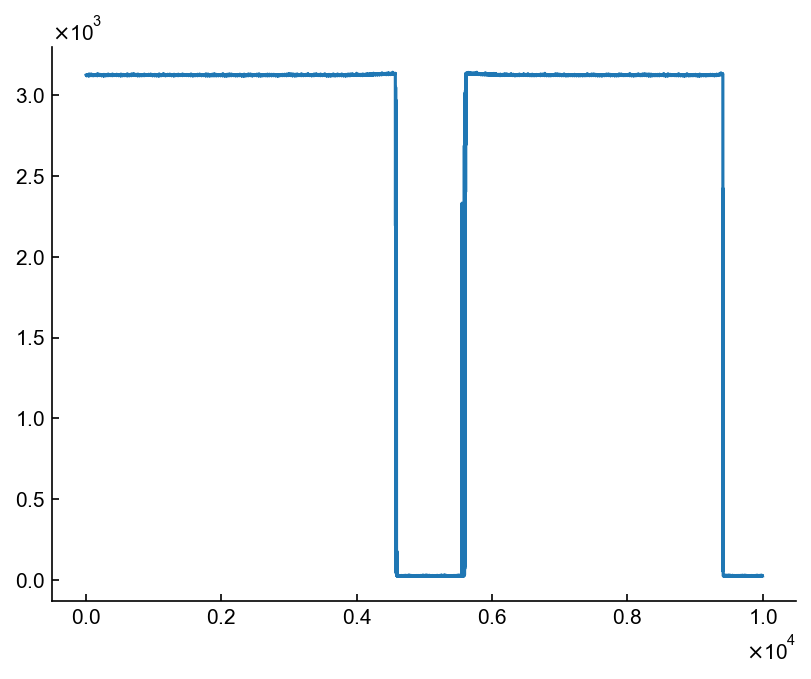

In [58]:
plt.plot(data[0,0:10000])

In [146]:
res = np.convolve(data[0,:], np.ones(30), mode='valid')
cross = np.diff(1 * (res > (np.ptp(res)/2 + np.min(res) )) != 0)

In [147]:
tstamps = np.where(cross)[0]
# tstamps = tstamps[np.less(tstamps,5000)]#100000)]

In [162]:
len(tstamps)

16832

In [149]:
np.diff(tstamps)

array([1019, 3816, 1775, ...,  839, 2987,  913], dtype=int64)

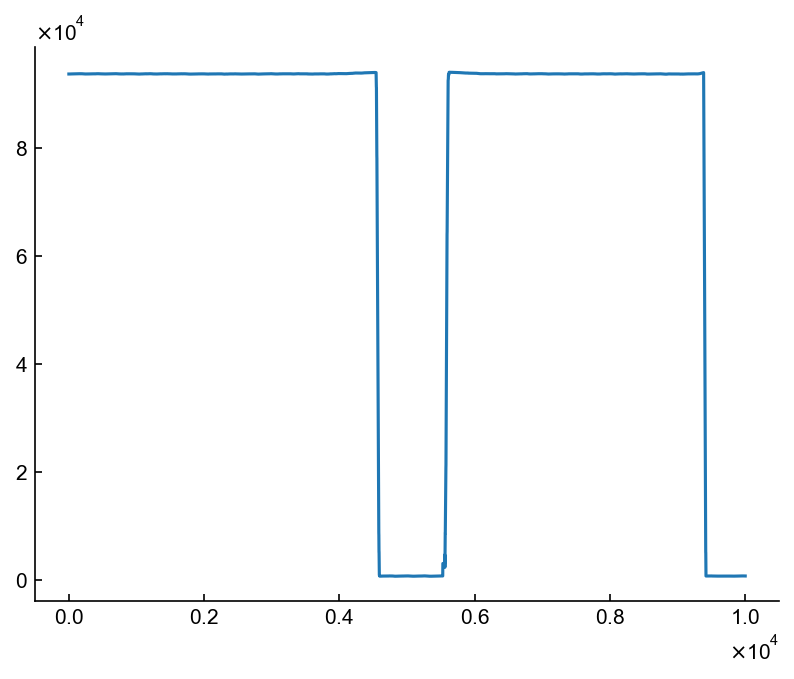

In [151]:
plt.plot(res[0:10000])
pass

In [152]:
tstamps = np.where(cross)[0]

In [153]:
len(tstamps)

16832

In [154]:
np.diff(tstamps)

array([1019, 3816, 1775, ...,  839, 2987,  913], dtype=int64)

In [181]:
tstamps_temp = []
laststamp = -np.Inf
for tstamp in tstamps:
    if tstamp > laststamp+30:
        tstamps_temp.append(tstamp-laststamp)
        laststamp = tstamp
tstamps_temp = np.array(tstamps_temp)
tstamps_temp = tstamps_temp[np.isfinite(tstamps_temp)]

In [182]:
tstamps_temp

array([1019., 3816., 1775., ...,  839., 2987.,  913.])

In [183]:
TTL_durations = np.array(tstamps_temp[0:len(tstamps_temp):2])/30

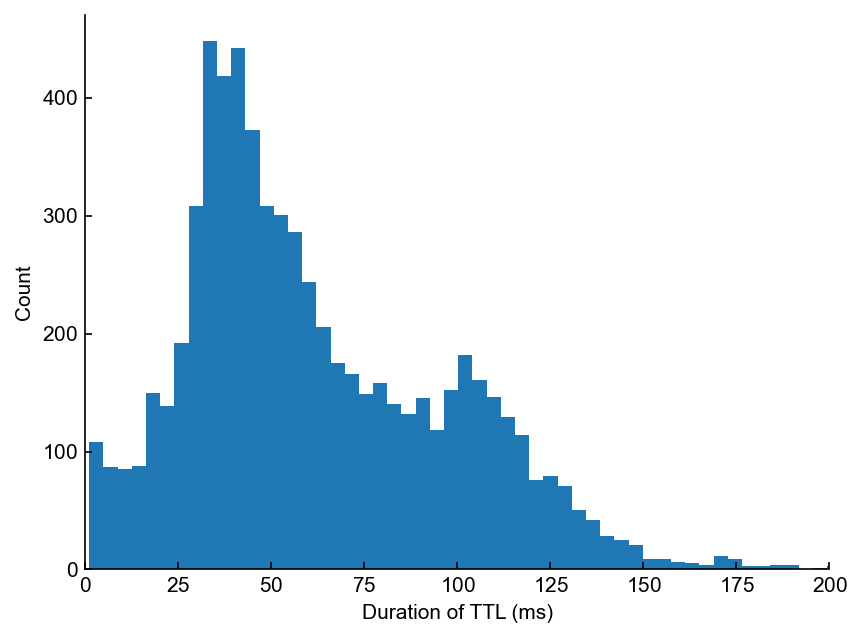

In [191]:
plt.hist(TTL_durations,bins=10000)
plt.xlim([0,200])
plt.xlabel('Duration of TTL (ms)')
plt.ylabel('Count')
plt.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Lick rate outlier BS_50 analysis.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=([]), bbox_inches='tight')

# Go only

In [12]:
lick_rate_preearly = []
lick_rate_prelate = []
lick_rate_preexpert = []
lick_rate_postearly = []
lick_rate_postlate = []
lick_rate_postexpert = []

post_stim = df['post-stimulus time limit'][0]

for row in df.iloc:
    if row['learning phase'] == 'pre early':
        lick_rate_preearly.append(row['average go lick rate']/post_stim)
    if row['learning phase'] == 'pre late':
        lick_rate_prelate.append(row['average go lick rate']/post_stim)
    if row['learning phase'] == 'pre expert':
        lick_rate_preexpert.append(row['average go lick rate']/post_stim)
        
    if row['learning phase'] == 'post early':
        lick_rate_postearly.append(row['average go lick rate']/post_stim)
    if row['learning phase'] == 'post late':
        lick_rate_postlate.append(row['average go lick rate']/post_stim)
    if row['learning phase'] == 'post expert':
        lick_rate_postexpert.append(row['average go lick rate']/post_stim)

lick_rate_preearly = np.array(lick_rate_preearly)
lick_rate_prelate = np.array(lick_rate_prelate)
lick_rate_preexpert = np.array(lick_rate_preexpert)
lick_rate_postearly = np.array(lick_rate_postearly)
lick_rate_postlate = np.array(lick_rate_postlate)
lick_rate_postexpert = np.array(lick_rate_postexpert)

lick_rate_prelate = np.random.RandomState(seed=42).choice(lick_rate_prelate,6)
lick_rate_preexpert = np.random.RandomState(seed=42).choice(lick_rate_preexpert,6)
lick_rate_postearly = np.random.RandomState(seed=42).choice(lick_rate_postearly,6)
lick_rate_postlate = np.random.RandomState(seed=42).choice(lick_rate_postlate,6)
lick_rate_postexpert = np.random.RandomState(seed=42).choice(lick_rate_postexpert,6)

In [13]:
print('ready')

ready


max = 4.0524017467248905
max = 7.153652392947103
max = 3.5454545454545454
max = 4.827586206896552
max = 5.982547993019197
max = 5.81039755351682
2.3055555555555554
4.2792650918635164
3.450038138825324
4.218155854753162
4.764525993883792
2.60153776571687


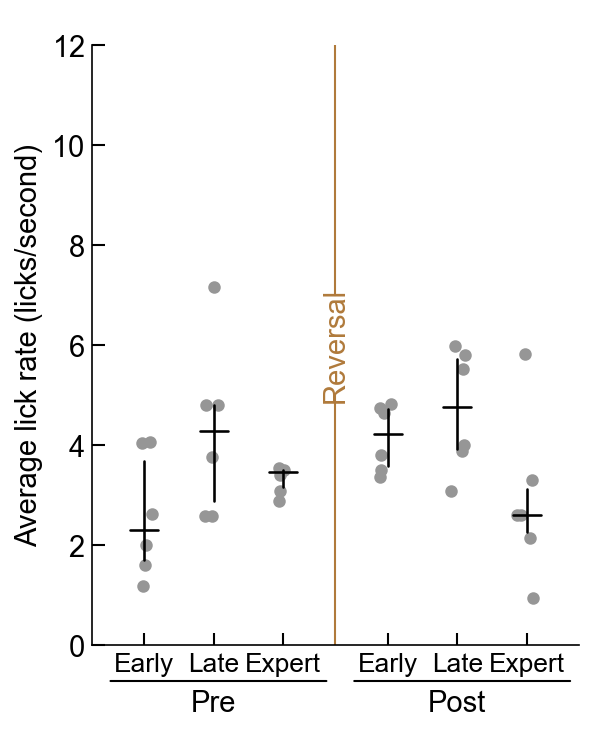

In [14]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 3.5
data = [lick_rate_preearly,lick_rate_prelate,lick_rate_preexpert,lick_rate_postearly,lick_rate_postlate,lick_rate_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

for d in data:
    print(f"max = {np.max(d)}")

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

# ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
# ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'grey'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    # median = np.mean(column)
    # Q1 = median - sem(column)
    # Q3 = median + sem(column)

    print(median)
    
    # ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    ax.plot([idx+polarity*switch_offset-0.2, idx+polarity*switch_offset+0.2], [median,median], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    X,Y = ilep.violin(column,width=0.4)
    ax.scatter(X+idx+polarity*switch_offset,Y,s=25,c=GOOD_GREY,zorder=8)


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,12])
# ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Average lick rate (licks/second)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = np.mean((ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-1],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+1],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Lick rate go trials anticipatory V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [15]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(lick_rate_preearly)
data_dec.prelate = np.abs(lick_rate_prelate)
data_dec.preexpert = np.abs(lick_rate_preexpert)
data_dec.postearly = np.abs(lick_rate_postearly)
data_dec.postlate = np.abs(lick_rate_postlate)
data_dec.postexpert = np.abs(lick_rate_postexpert)
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 6
pre-late    n = 6
pre-expert  n = 6
post-early  n = 6
post-late   n = 6
post-expert n = 6
pre-early  to pre-late   : 0.25373869862211
pre-late   to pre-expert : 0.3939393939393939
pre-early  to pre-expert : 0.3939393939393939
post-early to post-late  : 0.3939393939393939
post-late  to post-expert: 0.1948051948051948
post-early to post-expert: 0.1948051948051948


In [187]:
def clean_up_lick_train(lick_train_ms,timeout_ms = 10):
    actual_licks = []
    last_lick = -np.Inf
    for lick in lick_train_ms:
        if (lick - last_lick) >= timeout_ms:
            actual_licks.append(lick)
        last_lick = lick
    return np.array(actual_licks)

# Debug / Outlier Check

In [188]:
#https://onlinelibrary.wiley.com/doi/full/10.1111/j.1601-183X.2006.00293.x

In [210]:
cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

animals_list = []
sessions_list = []
learning_phase_list = []
avg_lick_rate_list = []
avg_go_lick_rate_list = []
post_stim_limit = []

post_stim = 0.2 #seconds
session = 'BS_49_14_AC.pickle'

sessionfile = ilep.loadSessionCached(act_directory,session)
licks = sessionfile.behavior.lick_times

allconds = ilep.getAllConditions(sessionfile,clust=None)

number_of_licks = []
trials = allconds['all_trials'].trials
trials = np.random.permutation(trials)
for trial in trials:
    trialstart = sessionfile.trials.starts[trial]
    trialend = trialstart + post_stim * sessionfile.meta.fs
    in_trial_licks = np.logical_and(np.greater(licks,trialstart),np.less(licks,trialend))
    in_trial_licks = licks[in_trial_licks]
    in_trial_licks = clean_up_lick_train(in_trial_licks/30, timeout_ms = 1)

    if np.sum(in_trial_licks) > 50 and np.sum(in_trial_licks) < 100:
        bad_trial = licks[in_trial_licks] - trialstart
    
    number_of_licks.append(len(in_trial_licks))
    
number_of_licks_go_only = []
trials = allconds['go'].trials
for trial in trials:
    trialstart = sessionfile.trials.starts[trial]
    trialend = trialstart + post_stim * sessionfile.meta.fs
    in_trial_licks = np.logical_and(np.greater(licks,trialstart),np.less(licks,trialend))
    number_of_licks_go_only.append(np.sum(in_trial_licks))

number_of_licks = np.array(number_of_licks)
licks = number_of_licks[np.greater(number_of_licks,0)]

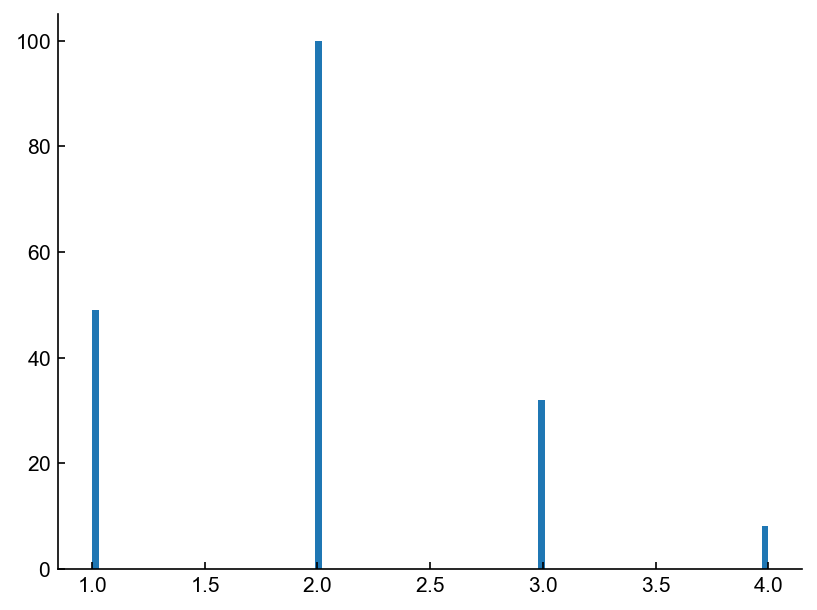

In [211]:
plt.hist(licks,bins=100)
pass

In [202]:
ILI = 200 / np.array(licks)
ILI = ILI[np.isfinite(ILI)]
print(ILI)

[ 22.22222222  10.52631579  18.18181818  18.18181818  11.76470588
  28.57142857  15.38461538  33.33333333   9.09090909  40.
  10.           6.25        50.          25.          33.33333333
  20.           2.02020202   2.08333333  28.57142857   1.47058824
  11.11111111   5.40540541  33.33333333  40.          33.33333333
   6.66666667  50.           5.55555556   7.14285714  33.33333333
   9.09090909  16.66666667  12.5         16.66666667  16.66666667
  40.          14.28571429  28.57142857   8.69565217  14.28571429
 100.           7.14285714  11.76470588   7.69230769   4.65116279
   6.06060606  40.          22.22222222  25.          40.
   5.12820513  28.57142857  13.33333333   7.14285714  20.
   4.44444444   6.25        14.28571429  11.11111111  28.57142857
  22.22222222   6.25         6.25        40.          40.
  20.           5.71428571  33.33333333   5.55555556  22.22222222
  16.66666667   2.98507463  11.76470588  40.           6.4516129
  16.66666667  33.33333333   8.69565217  40

In [203]:
np.mean(licks)

20.91005291005291

(0.0, 200.0)

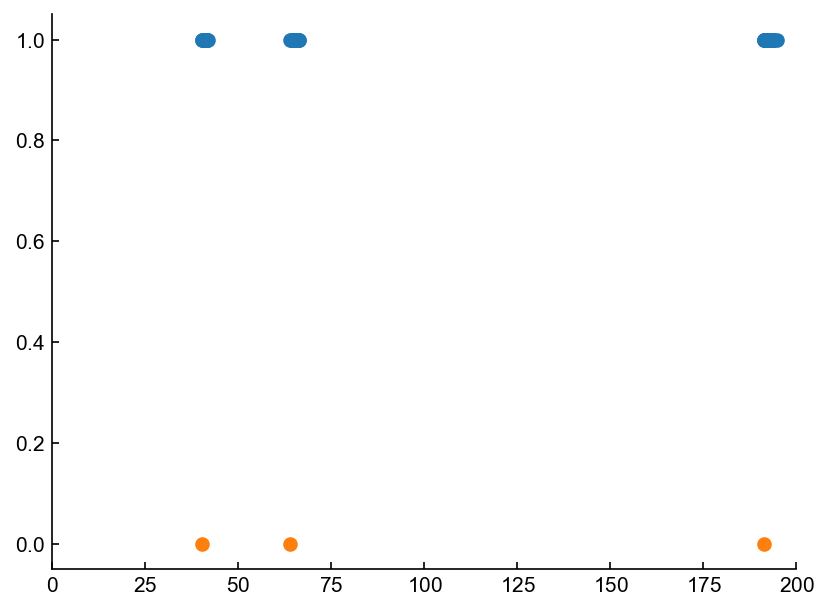

In [195]:
plt.scatter(bad_trial/30,np.ones_like(bad_trial))
plt.scatter(clean_up_lick_train(bad_trial/30),np.zeros_like(clean_up_lick_train(bad_trial/30)))
plt.xlim([0,200])

In [48]:
target_phase = 'pre late'
subset_df = df[df['learning phase'] == target_phase]
un_animals = np.unique(subset_df['animal'])
for animal in un_animals:
    go_rate = subset_df[subset_df['animal']==animal]['average go lick rate']
    print(f"{animal} = {np.mean(go_rate)}")

BS_40 = 0.5871062893717331
BS_49 = 1.1149649460923972
BS_50 = 1.1643738675708384
BS_70 = 0.43356643356643354


In [49]:
subset_df

,animal,session,learning phase,average lick rate,average go lick rate,post-stimulus time limit
5,BS_40,BS_40_10_AC.pickle,pre late,0.545000,0.795620,0.2
6,BS_40,BS_40_11_AC.pickle,pre late,0.466368,0.707483,0.2
16,BS_40,BS_40_2_AC.pickle,pre late,0.232143,0.471503,0.2
17,BS_40,BS_40_3_AC.pickle,pre late,0.184932,0.440217,0.2
18,BS_40,BS_40_4_AC.pickle,pre late,0.282000,0.440625,0.2
19,BS_40,BS_40_5_AC.pickle,pre late,0.335317,0.635338,0.2
20,BS_40,BS_40_6_AC.pickle,pre late,0.360601,0.563969,0.2
21,BS_40,BS_40_7_AC.pickle,pre late,0.531667,0.837270,0.2
22,BS_40,BS_40_8_AC.pickle,pre late,0.275862,0.391931,0.2
44,BS_49,BS_49_10_AC.pickle,pre late,0.487805,0.784314,0.2
